# Analysis of Benchmark Results

## 0. Utilities

We first set up some imports and helpful functions.

In [26]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.patches as mpatches

In [27]:
def filter_rows(df, pred):
    return df[df.apply(pred, axis=1)]


def summarize_answers(df, reduced=True):
    solvers = df.columns.get_level_values(0).unique()
    answers = [
        "sat", "unsat", "unknown", "wrong", "error", "timeout", "memout", "no answer",
        "segmentation fault", "segfault", "abort", "invalid", "success",
    ]

    data = []
    data.append(tuple([len(df[~df[(solver, "answer")].isnull()]) for solver in solvers])) # count
    for answer in answers:
        r = []
        for solver in solvers:
            vc = df[(solver, "answer")].value_counts()
            if answer in vc:
                r.append(vc[answer])
            else:
                r.append(0)
        data.append(tuple(r))
    data.append(tuple([data[1][i] + data[2][i] for i in range(len(solvers))]))  # solved

    result = pd.DataFrame(data, index=["count"] + answers + ["solved"], columns=solvers)
    if reduced:
        return filter_rows(result, (lambda x : any([x[c] != 0 for c in result.columns])))
    else:
        return result 


def virtual_portfolio(df, solvers, name):
    data = []
    for _, row in df.iterrows():
        s = solvers[0]
        for s2 in solvers:
            a = row[(s, "answer")]
            t = row[(s, "runtime")]
            a2 = row[(s2, "answer")]
            t2 = row[(s2, "runtime")]
            if a2 in ["sat", "unsat"] and not a in ["sat", "unsat"]: s = s2
            elif not a2 in ["sat", "unsat"] and a in ["sat", "unsat"]: continue
            elif a2 != "unknown" and a == "unknown": s = s2
            elif a2 == "unknown" and a != "unknown": continue
            elif a2 != "memout" and a == "memout":   s = s2
            elif a2 == "memout" and a != "memout":   continue
            elif int(t2) < int(t): s = s2

        data.append(tuple([row[(s, "answer")], row[(s, "runtime")]]))
    return pd.DataFrame(data, df.index, columns=pd.MultiIndex.from_product([[name], ["answer", "runtime"]]))

In [28]:
# Set up styles for plotting

linestyles = [
    "-",
    "--",
    ":",
    "-.",
    (5, (10, 3)),
    (0, (5, 10)),
    (0, (5, 5)),
]
colors = [
    "#000000",
    "#117733",
    "#AA4499",
    "#CC6677",
    "#332288",
    "#882255",
    "#44AA99",
]
plt.rcParams["axes.prop_cycle"] = plt.cycler(
    "color", colors
) + plt.cycler("linestyle", linestyles)

## 1. Loading the Data

In [29]:
df = pd.read_csv("stats.csv", header=[0,1], index_col=0)
simple_pf = virtual_portfolio(df, ["Simple-3", "Simple-4", "Simple-5", "Simple-6"], "Simple-*")
pwl_pf = virtual_portfolio(df, ["PWL-2", "PWL-4", "PWL-6"], "PWL-*")
df = pd.concat([df, simple_pf, pwl_pf], axis=1)

/tmp/ipykernel_3857/2806051569.py:1: DtypeWarning: Columns (126,163,412,449,698,735,984,1021,1270,1307,1556,1593,1842,1879,2128,2167,2416,2455,2704,2743,2992,3029) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("stats.csv", header=[0,1], index_col=0)


In [30]:
summarize_answers(df)

,Baseline,Simple-3,Simple-4,Simple-5,Simple-6,Dynamic,Taylor,PWL-2,PWL-4,PWL-6,Outside,Simple-*,PWL-*
count,1684,1684,1684,1684,1684,1684,1684,1684,1684,1684,1684,1684,1684
sat,659,685,681,687,687,689,675,660,667,667,639,695,688
unsat,649,666,673,666,671,677,663,649,646,649,630,681,667
timeout,376,333,330,331,326,318,346,375,371,368,415,308,329
solved,1308,1351,1354,1353,1358,1366,1338,1309,1313,1316,1269,1376,1355


## 2. Reproducing the Plots from the Paper

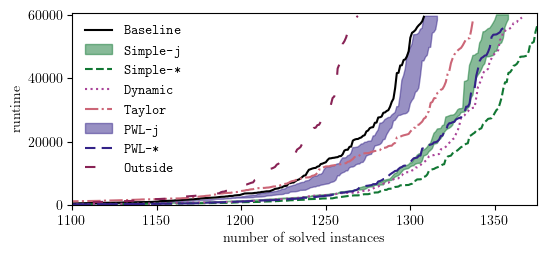

In [33]:
fig = plt.figure(figsize=(6,2.5))
plt.rcParams.update({
    "text.usetex": True,
    "font.family": 'CM'
})

# cumulate number of solved instances
stats = {}
for solver in df.columns.get_level_values(0).unique():
    solved = df.loc[df[(solver, "answer")].isin(["sat", "unsat"])].copy()
    solved.loc[:, "num"] = 1
    solved = solved.groupby([(solver, "runtime")]).count()
    solved.loc[:, "num"] = solved["num"].cumsum()
    solved = solved[["num"]]
    solved = solved.reset_index().set_index("num")
    stats[solver] = solved

ax = plt.gca()

# plot area for Simple-j variants
degs = ["Simple-3", "Simple-4", "Simple-5", "Simple-6"]
xfill = np.unique(np.concatenate([stats[s].index for s in degs]))
yfills = [np.interp(xfill, stats[s].index, stats[s][(s,"runtime")].values) for s in degs]
ymax = np.max(yfills, axis=0)
ymin = np.min(yfills, axis=0)
ax.fill_between(xfill, ymin, ymax, interpolate=True, color='#117733', alpha=0.5)

# plot area for PWL-j variants
pwls = ["PWL-2", "PWL-4", "PWL-6"]

xfill = np.unique(np.concatenate([stats[s].index for s in pwls]))
yfills = [np.interp(xfill, stats[s].index, stats[s][(s,"runtime")].values) for s in pwls]
ymax = np.max(yfills, axis=0)
ymin = np.min(yfills, axis=0)
ax.fill_between(xfill, ymin, ymax, interpolate=True, color='#332288', alpha=0.5)

# plot all other variants
for solver in ["Baseline", "Simple-*", "Dynamic", "Taylor", "PWL-*", "Outside"]:
    stats[solver].plot.line(ax=ax)

ax.set_ylabel("runtime")
ax.set_xlabel("number of solved instances")
ax.set_xlim([1100, 1375])
ax.set_ylim([0, 60600])
#ax.set_yscale("log")

lines, labels = ax.get_legend_handles_labels()
[base,vbs,dyn,tay,vbp,out] = lines
ax.legend(
    [
        base,
        mpatches.Patch(color='#117733',alpha=0.5),
        vbs,
        dyn,
        tay,
        mpatches.Patch(color='#332288',alpha=0.5),
        vbp,
        out
    ],
    [
        r"\texttt{Baseline}",
        r"\texttt{Simple-j}",
        r"\texttt{Simple-*}",
        r"\texttt{Dynamic}",
        r"\texttt{Taylor}",
        r"\texttt{PWL-j}",
        r"\texttt{PWL-*}",
        r"\texttt{Outside}",
    ],
    frameon=False
)
plt.show()

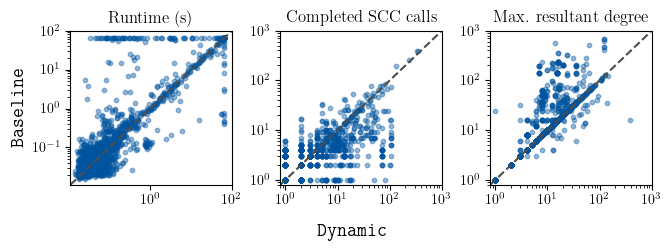

In [34]:
fig = plt.figure(figsize=(7.5,2))

plt.rcParams.update({
    "text.usetex": True,
    "font.family": 'CM'
})

def scatter_equal_line(ax, v_min, v_max):
    ax.set_xlim(v_min,v_max)
    ax.set_ylim(v_min,v_max)
    ax.plot([v_min, v_max], [v_min, v_max], ls="--", c=".3")

# first plot: runtimes
plt.subplot(1,3,1)

plt.scatter(
    x=df.apply((lambda x: x[("Dynamic","runtime")] / 1000), axis=1),
    y=df.apply((lambda x: x[("Baseline","runtime")] / 1000), axis=1),
    c="#00549F",
    alpha=0.4,
    s=10,
)
ax = plt.gca()
scatter_equal_line(ax, 0.011,100)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel(r"\texttt{Baseline}", fontsize=14)
ax.set_xlabel(None)
ax.title.set_text("Runtime (s)")

# second plot: computed cells
plt.subplot(1,3,2)

plt.scatter(
    x=df[("Dynamic","mcsat-explanation-onecell_explanation_success")],
    y=df[("Baseline","mcsat-explanation-onecell_explanation_success")],
    c="#00549F",
    alpha=0.4,
    s=10,
)

ax = plt.gca()
scatter_equal_line(ax, 0.8, 1000)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel(None)
ax.set_xlabel(None)
ax.title.set_text("Completed SCC calls")

# third plot: maximum resultant degree
plt.subplot(1,3,3)

plt.scatter(
    x=df[("Dynamic","smtrat-cadcells_projections.resultant.total_degree.max")],
    y=df[("Baseline","smtrat-cadcells_projections.resultant.total_degree.max")],
    c="#00549F",
    alpha=0.4,
    s=10,
)

ax = plt.gca()
scatter_equal_line(ax, 0.8, 1000)
ax.set_xscale("log")
ax.set_yscale("log")
ax.title.set_text("Max. resultant degree")

# general
fig.text(0.5, -0.15, r'\texttt{Dynamic}', ha='center', fontsize=14)
plt.subplots_adjust(wspace=0.3, hspace=0)
plt.show()